# Is the network right?

We inspect trained models to understand if:
- the model is able to extract visual features

In [1]:
import torch, gym, sneks, sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('..')
from dqn.qnetwork import QNetwork
from common.atari_wrappers import ScaledFloatFrame
from common.pytorch_utils import ImageToPyTorch, NHWC_from_NCHW

## Creating the testing environment

In [49]:
def make_env(env_name, rnd_seed):
    env = gym.make(env_name)
    env = ScaledFloatFrame(env)
    env = ImageToPyTorch(env)
    env.seed(rnd_seed)
    return env

env = make_env('snek-rgb-16-v1', 42)

In [50]:
obs = env.reset()
done = False

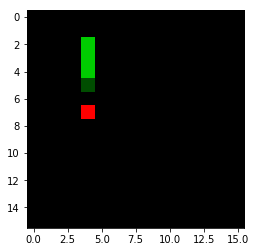

In [51]:
plt.imshow(NHWC_from_NCHW(obs))
plt.show();

ACTIONS:
  - 0: UP
  - 1: RIGHT
  - 2: DOWN
  - 3: LEFT

## Loading the trained network

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = torch.load('../smally_baseline.pth', map_location="cuda" if torch.cuda.is_available() else "cpu")
print("ARCH:", state['arch'])
net = QNetwork(env.observation_space, env.action_space, arch=state['arch']).to(device)
net.load_state_dict(state['state_dict'])

ARCH: smally


In [53]:
net

QNetwork(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
  )
  (head): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3136, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [54]:
net(torch.from_numpy(np.expand_dims(obs, 0)).to(device))

tensor([[1.7802, 1.8316, 1.8010, 1.9047]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [55]:
layer1 = net.conv_layers[0](torch.from_numpy(np.expand_dims(obs, 0)).to(device))
layer1 = NHWC_from_NCHW(layer1.cpu().detach().numpy())[0]
print(layer1.shape)

(14, 14, 16)


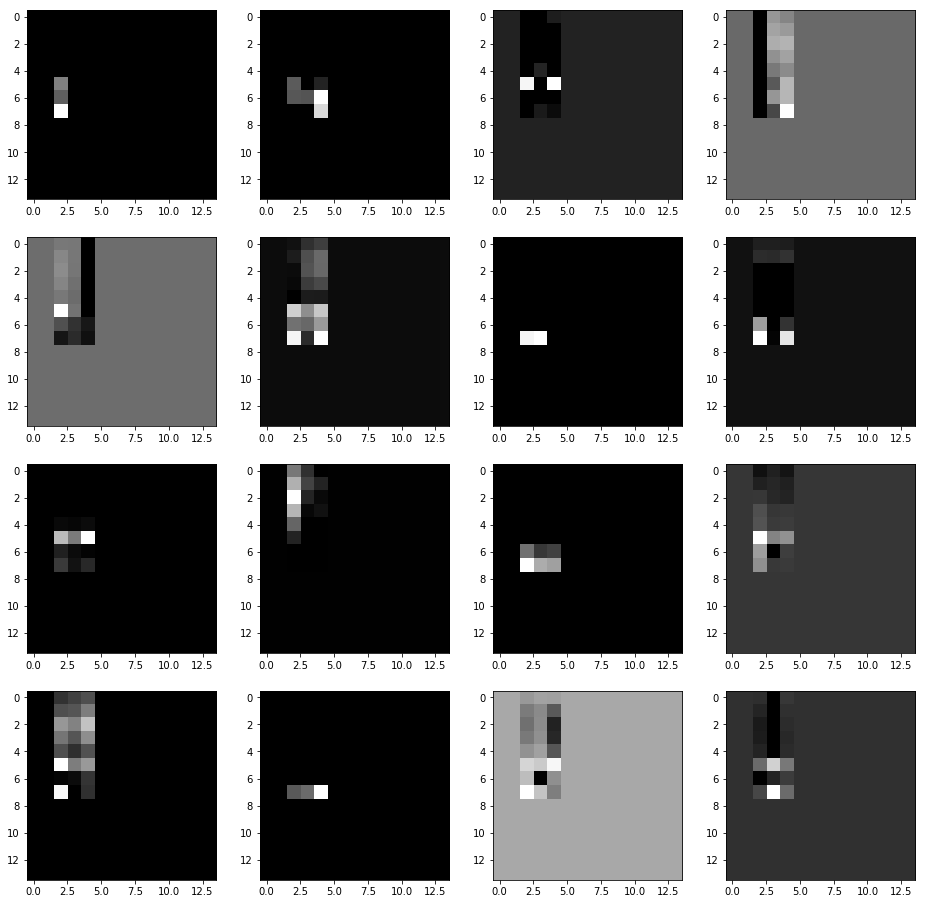

In [56]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(16):
    ax[i//4, i%4].imshow(layer1[:,:,i], cmap='gray')
plt.show();

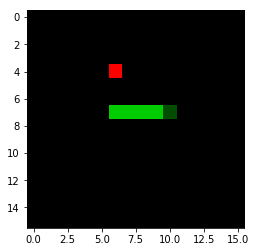

tensor([[1.7783, 1.8111, 1.7787, 1.8770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
DONE: False


In [68]:
if not done:
    action_values = net(torch.from_numpy(np.expand_dims(obs, 0)).to(device))
    action = action_values.argmax(dim=1)[0].item()
    obs, reward, done, _ = env.step(action)
    plt.imshow(NHWC_from_NCHW(obs))
    plt.show();
    action_values = net(torch.from_numpy(np.expand_dims(obs, 0)).to(device))
    print(action_values)
    print('DONE:', done)